In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

# Semantic Segmentation

## Goals

- Semantic Segmentation: architecture-Design, training and evaluation of models
- Upsampling: understand and apply different techniques
- Instance Segmentation: Anwenden von Pre-Trained Modellen, Verstehen & Evaluieren der Outputs

## Setup

Let's define paths, install & load the necessary Python packages.

**Optional: Save the notebook to your personal google drive to persist changes.**

**Optional: Change runtime to a GPU instance (if using Google Colab)** 

Mount your google drive to store data and results (if running the code in Google Colab).

In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

**Modify the following paths if necessary.**

That is where your data will be stored.

In [4]:
from pathlib import Path

if IN_COLAB:
    DATA_PATH = Path("/content/drive/MyDrive/bveri")
else:
    DATA_PATH = Path("../../workspace/code/data")

Install `dl_cv_lectures`

In [5]:
try:
    import dl_cv_lectures

    print("dl_cv_lectures installed, all good")
except ImportError as e:
    import os

    if Path("/workspace/code/src").exists():
        print("Installing from local repo")
        os.system("cd /workspace/code  && pip install -e .")
    else:
        print("Installing from git repo")
        os.system("pip install git+https://github.com/i4Ds/bveri-exercises-hs2024")

dl_cv_lectures installed, all good


Load all packages

In [6]:
from pathlib import Path
from typing import Callable

import numpy as np
import seaborn as sns
import torch
import torchshow as ts
from IPython.display import Image
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from torchvision.transforms.v2 import functional as TF

Define a default device for your computations.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


## Stanford Background Dataset

Let's take a look at the [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html).

Let's download the data.


In [8]:
from dl_cv_lectures.data import stanford_background

stanford_background.download(DATA_PATH)

Let's take a look at how the dataset is organized and visualize some images.

(this example command only works on Linux)

In [9]:
!find {DATA_PATH}/stanford_background_dataset/ -type d

FIND: Parameterformat falsch


Let's inspect the images directory.

In [10]:
!find {DATA_PATH}/stanford_background_dataset/stanford_background_dataset/images -type f | head -n 10

FIND: Parameterformat falsch
Der Befehl "head" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


Let's inspect the labels directory.

In [11]:
!find {DATA_PATH}/stanford_background_dataset/stanford_background_dataset/labels -type f | head -n 10

FIND: Parameterformat falsch
Der Befehl "head" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


Now we read the first image and display it.

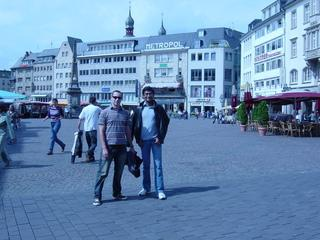

In [12]:
img_sbds = Image.open(
    DATA_PATH.joinpath(
        "stanford_background_dataset/stanford_background_dataset/images/0000047.jpg"
    )
)
label_path = DATA_PATH.joinpath(
    "stanford_background_dataset/stanford_background_dataset/labels/0000047.regions.txt"
)

display(img_sbds)

**Task**: Look at a couple of more images.

torch.Size([9, 240, 320])

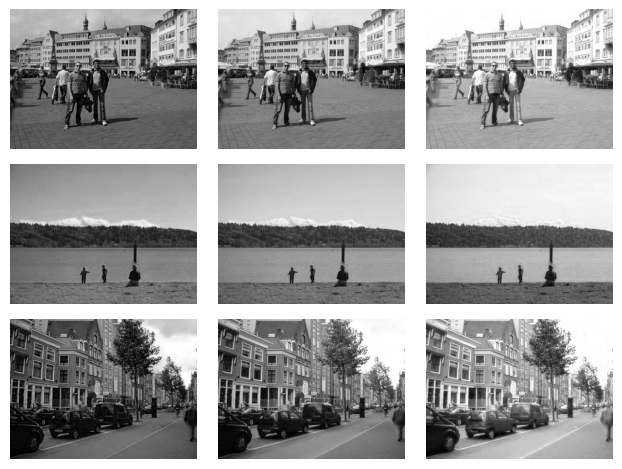

In [13]:
root_path = DATA_PATH.joinpath(
    "stanford_background_dataset/stanford_background_dataset"
)
img_paths = list((root_path / "images").glob("*jpg"))
imgs = []

for i in range(3):
    img = Image.open(img_paths[i])
    imgs.append(TF.to_image(img).to(torch.float32) / 255)


x_batch = torch.concat(imgs)
x_batch.shape
ts.show(x_batch)

**Task**: Try to figure out what the ".regions.txt" files are about.

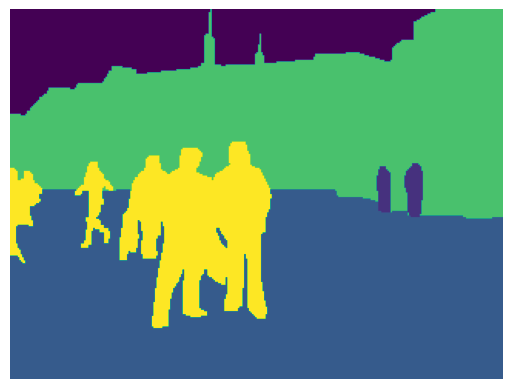

In [14]:
def _parse_regions(path: Path) -> np.ndarray:
    with open(path, "r") as file:
        return np.array([list(map(int, line.split())) for line in file])


labels = _parse_regions(label_path)
labels.shape

plt.imshow(labels)
plt.axis("off")
plt.show();

## Build a Dataset

We define a `torch.utils.data.Dataset` and display an image and it's segmentation map.

In [15]:
class StanfordBackgroundDataset(Dataset):
    def __init__(
        self,
        root_path: Path,
        transform_images: Callable = None,
        transform_labels: Callable = None,
    ):
        """
        Initializes the dataset.

        Args:
            root_path (Path): Path to the dataset directory.
            transform_images (callable, optional): Transformation function for images.
            transform_labels (callable, optional): Transformation function for labels.
        """
        self.root_path = root_path
        self.transform_images = transform_images
        self.transform_labels = transform_labels
        self.image_paths = list((root_path / "images").glob("*.jpg"))
        self.classes = [
            "sky",
            "tree",
            "road",
            "grass",
            "water",
            "building",
            "mountain",
            "foreground object",
        ]

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(
        self, idx: int
    ) -> tuple[torch.Tensor | Image.Image, torch.Tensor, torch.Tensor]:
        """
        Retrieves the image and corresponding label masks for a given index.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing:
                - image (torch.Tensor | Image.Image): The transformed image or original image.
                - label_masks (torch.Tensor): A binary mask tensor of shape (K, H, W) where K is the number of classes.
                  Each channel represents the binary mask for a specific class.
                - labels_tensor (torch.Tensor): A segmentation map tensor of shape (1, H, W) indicating class indices
                for each pixel.
        """

        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        label_path = self.root_path / f"labels/{image_path.stem}.regions.txt"
        labels = self._parse_regions(label_path)

        labels_tensor = (
            torch.tensor(labels).unsqueeze(0).clamp(0, len(self.classes) - 1)
        )
        label_masks = torch.zeros(len(self.classes), *labels.shape).scatter_(
            0, labels_tensor, 1
        )

        if self.transform_images:
            image = self.transform_images(image)
        if self.transform_labels:
            label_masks = self.transform_labels(label_masks)
            labels_tensor = self.transform_labels(labels_tensor)

        return image, label_masks, labels_tensor

    def _parse_regions(self, path: Path) -> np.ndarray:
        with open(path, "r") as file:
            return np.array([list(map(int, line.split())) for line in file])

Create an object of the `StanfordBackgroundDataset` class. 

Retrieve the first observation and display:

- the image
- segmentation map
- all binary class maps

Use `torchshow` for simplicity.


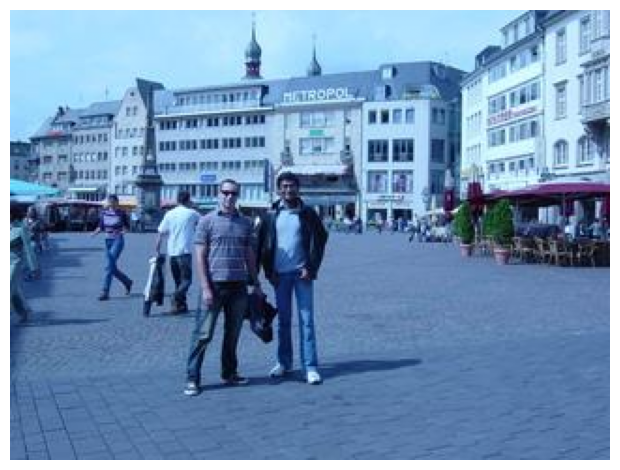

In [41]:
ds_train = StanfordBackgroundDataset(root_path)
image, label_masks, label_tensor = ds_train[0]
ts.show(image)

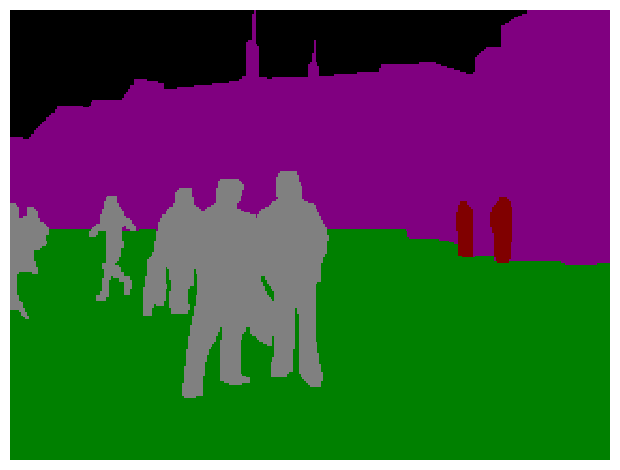

In [42]:
ts.show(label_tensor)

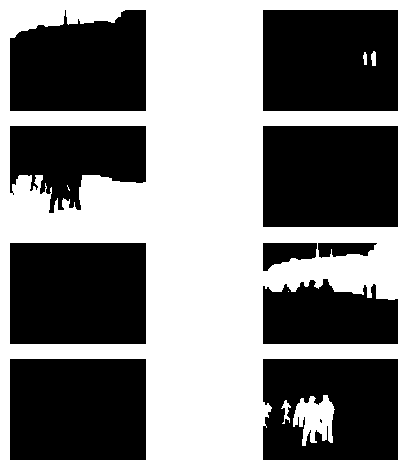

In [43]:
ts.show(label_masks)

**Task**: Which is the mask for sky? Which the one for trees? How can you find our for sure?

## Fully-Convolutional Network

Implement a fully convolutional network with an encoder-decoder architecture. Complete the following classes.

We start by implementing an `EncoderBlock`. It should implement the following operations:

- **Convolution -> Batch Normalization -> ReLU -> Convolution (stride = 2) -> Batch Normalization -> ReLU**

Complete the following code.

In [19]:
from torch import nn
from torch.nn import functional as F


class EncoderBlock(nn.Module):
    """A basic encoder block that performs convolution, normalization, and activation."""

    def __init__(self, in_channels: int, out_channels: int, kernel_size=3, padding=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, in_channels, kernel_size, stride=1, padding=padding
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride=2, padding=padding
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

Next, we stack the EncoderBlocks to an `Encoder` class.

In [20]:
class Encoder(nn.Module):
    """Encodes an image to a low-dimensional representation.

    Args:
        num_channels_in (int): Number of input channels (e.g., 3 for RGB images).
        num_channels (list[int]): Number of output channels for each block.
            Each block reduces spatial dimensionality by half.
    Input:
        image batch of shape (N, C, H, W)

    Output:
        image batch of shape (N, C2, H / S, W / S), where S is the global stride.
    """

    def __init__(self, num_channels_in: int, num_channels: list[int]):
        super().__init__()

        num_channels = [num_channels_in] + num_channels
        self.layers_ = nn.ModuleList()
        for in_channels, out_channels in zip(num_channels, num_channels[1:]):
            self.layers_.append(
                EncoderBlock(in_channels=in_channels, out_channels=out_channels)
            )

    def forward(self, x):
        for layer in self.layers_:
            x = layer(x)
        return x

**Question**: How many Encoder Blocks do you need to reduce a 1024 x 1024 image to a single scalar? How many output-channels would you have if you double the number of channels with each block (first block extracts 16 channels)?

**Answer**: When each block reduces the dimensionality by a factor of 2 then you would need 10 blocks to get a single scalar. The number of output channels would also increase exponentially  and you would end up with 16 * 2<sup>9</sup> which would result in 2<sup>13</sup> number of output channels

Now we do the same for the Decoder part. First we implement a Decoder block which upsamples the input.

In [21]:
class DecoderBlock(nn.Module):
    """A basic decoder block that performs transposed convolution, normalization, and activation."""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size=3,
        stride=2,
        padding=1,
        output_padding=1,
    ):
        super().__init__()

        self.deconv1 = nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        )

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size, stride=1, padding=padding
        )

        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.deconv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

And we combine the blocks to a Decoder.

In [22]:
class Decoder(nn.Module):
    """Decodes a low-dimensional representation back to an image.

    Args:
        num_channels_in (int): Number of input channels (output of encoder)
        num_channels (list[int]): Number of channels for each block, reversed from the encoder configuration.
    Input:
        feature map of shape (N, C, H, W)
    Output:
        image batch of shape (N, C_out, H_out, W_out), where C_out is typically the original input channels.
    """

    def __init__(self, num_channels_in, num_channels: list[int]):
        super().__init__()

        num_channels = [num_channels_in] + num_channels

        # Reverse the list of channels to create the symmetrical structure
        self.layers_ = nn.ModuleList()
        for in_channels, out_channels in zip(num_channels, num_channels[1:]):
            self.layers_.append(
                DecoderBlock(in_channels=in_channels, out_channels=out_channels)
            )

    def forward(self, x):
        for layer in self.layers_:
            x = layer(x)
        return x

Now implement the `EncoderDecoder` class.

In [23]:
class EncoderDecoder(nn.Module):
    """Encoder-Decoder architecture for image-to-image tasks.
    Args:
        encoder (nn.Module): The encoder network that reduces the
            spatial dimensions and extracts features from the input.
        decoder (nn.Module): The decoder network that upsamples the
            features and reconstructs the output image.
        num_in_channels (int): Number of input channels (e.g., 3 for RGB images).
        num_in_encoder_channels (int): Number of channels for the input
            convolution layer, used to match the encoder's initial channel size.
        num_out_decoder_channels (int): Number of channels for the final
            output from the decoder before the output layer.
        num_output_channels (int): Number of output channels (e.g., 1 for grayscale or
            3 for RGB).

    Input:
        x (torch.Tensor): Image batch of shape (N, num_in_channels, H, W).

    Output:
        torch.Tensor: Processed image batch of shape (N, num_output_channels, H, W).
    """

    def __init__(
        self,
        encoder,
        decoder,
        num_in_channels,
        num_in_encoder_channels,
        num_out_decoder_channels,
        num_output_channels,
    ):
        super().__init__()
        self.input = nn.Conv2d(
            num_in_channels,
            num_in_encoder_channels,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
        )
        self.encoder = encoder
        self.decoder = decoder

        self.output = nn.Conv2d(
            num_out_decoder_channels, num_output_channels, kernel_size=3, padding=1
        )

    def forward(self, x):
        x = self.input(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.output(x)
        return x

Überprüfen Sie die Architektur. Z.B. das die Output-Shape korrekt ist. Wir möchten pro Klasse eine eigene Maske erstellen.

In [36]:
import torchinfo

num_channels_encoder = [16, 32, 64, 128, 256]
num_channels_decoder = [128, 64, 32, 16, 8]
encoder = Encoder(num_channels_in=8, num_channels=num_channels_encoder)
decoder = Decoder(num_channels_in=256, num_channels=num_channels_decoder)
num_classes = len(ds_train.classes)
net = EncoderDecoder(
    encoder,
    decoder,
    num_in_channels=3,
    num_output_channels=num_classes,
    num_in_encoder_channels=8,
    num_out_decoder_channels=8,
)

net = net.to(device)
print(torchinfo.summary(net, input_size=(1, 3, 256, 256)))

Layer (type:depth-idx)                        Output Shape              Param #
EncoderDecoder                                [1, 8, 256, 256]          --
├─Conv2d: 1-1                                 [1, 8, 256, 256]          224
├─Encoder: 1-2                                [1, 256, 8, 8]            --
│    └─ModuleList: 2-1                        --                        --
│    │    └─EncoderBlock: 3-1                 [1, 16, 128, 128]         1,800
│    │    └─EncoderBlock: 3-2                 [1, 32, 64, 64]           7,056
│    │    └─EncoderBlock: 3-3                 [1, 64, 32, 32]           27,936
│    │    └─EncoderBlock: 3-4                 [1, 128, 16, 16]          111,168
│    │    └─EncoderBlock: 3-5                 [1, 256, 8, 8]            443,520
├─Decoder: 1-3                                [1, 8, 256, 256]          --
│    └─ModuleList: 2-2                        --                        --
│    │    └─DecoderBlock: 3-6                 [1, 128, 16, 16]          44

### Model-Training and Metrics

Now, train the model and monitor your progress.

In [38]:
from torchvision import transforms

batch_size = 64

tr_images = transforms.Compose(
    [
        transforms.CenterCrop((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        #   transforms.ConvertImageDtype(torch.float),
    ]
)

tr_labels = transforms.Compose([transforms.CenterCrop((256, 256))])

ds = StanfordBackgroundDataset(
    root_path, transform_images=tr_images, transform_labels=tr_labels
)
ds_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

Complete the calculation of pixel accuracy.

In [ ]:
import torch.optim as optim

torch.manual_seed(123)

# Parameters
num_epochs = 32

# create model
num_classes = len(ds.classes)
num_channels_encoder = [16, 32, 64, 128, 256]
num_channels_decoder = [128, 64, 32, 16, 8]

encoder = Encoder(num_channels_in=8, num_channels=num_channels_encoder)
decoder = Decoder(num_channels_in=256, num_channels=num_channels_decoder)
encoder_decoder = EncoderDecoder(
    encoder,
    decoder,
    num_in_channels=3,
    num_output_channels=num_classes,
    num_in_encoder_channels=8,
    num_out_decoder_channels=8,
)

encoder_decoder = encoder_decoder.to(device)

# Create Loss-Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder_decoder.parameters())

pbar = tqdm(total=num_epochs * len(ds_loader))

step = 0
for epoch in range(0, num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(ds_loader):

        images, label_masks, label_images = data

        # Forward-Pass
        optimizer.zero_grad()
        logits = encoder_decoder(images.to(device))
        probs = F.softmax(logits, dim=1)

        # Optimize
        loss = criterion(logits, label_masks.to(device))
        loss.backward()
        optimizer.step()

        # Calculate Pixel-Accuracy - calculate predicted class per pixel and compare
        # to ground truth class
        pred = probs.argmax(dim=(1), keepdim=True).cpu()
        pixel_acc = (label_images == pred).to(torch.float).mean()

        # print statistics
        running_loss += loss.item()
        running_acc += pixel_acc
        step += 1
        print_every = 10
        if (i % print_every) == (print_every - 1):
            desc = f"Epoch: {epoch + 1}, Iteration: {i + 1:5d}] Loss: {running_loss / print_every:.3f} Acc: {running_acc / print_every:.3f}"
            _ = pbar.update(print_every)
            _ = pbar.set_description(desc)
            running_loss = 0.0
            running_acc = 0.0
pbar.close()

print("Finished Training")

  0%|          | 0/384 [00:00<?, ?it/s]

Finished Training


Visualize the prediction on one image and commpare with the annotated _segmentation map_. Use `torchshow` for simplicity.

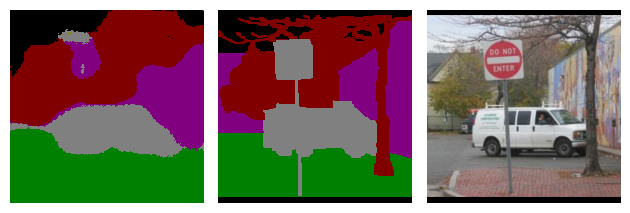

In [45]:
logits = encoder_decoder(images.to(device))
probs = F.softmax(logits, dim=1)
pred = torch.argmax(probs, dim=1)
pred_img = pred[0]

ts.show([pred_img, label_images[0], images[0]])

## Upsampling

We now look at a few upsampling techniques.

C:\Users\viety\AppData\Local\Temp\ipykernel_16824\2329496154.py:33: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  display_arrays([np.array(to_upsample[0, :, :])], ["input"])


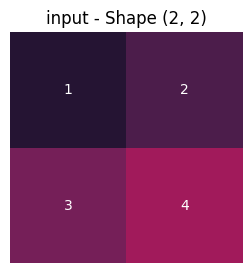

In [28]:
to_upsample = torch.tensor([[1, 2], [3, 4]]).unsqueeze(0).to(torch.float)

to_upsample_2 = torch.concat([to_upsample, to_upsample], dim=2)

to_upsample_2 = torch.concat([to_upsample_2, to_upsample_2], dim=1)


def display_arrays(arrays: list[np.ndarray], titles: list[str]):
    """Display Arrays"""
    num_arrays = len(arrays)
    kwargs = {
        "annot": True,
        "cbar": False,
        "vmin": 0,
        "vmax": 10,
        "xticklabels": False,
        "yticklabels": False,
    }
    fig, ax = plt.subplots(figsize=(3 * num_arrays, 3), ncols=num_arrays)

    # handle single and multi-array plots
    if num_arrays > 1:
        axes = ax.flatten()
    else:
        axes = [ax]

    for i, (array, title) in enumerate(zip(arrays, titles)):
        sns.heatmap(array, **kwargs, ax=axes[i]).set(
            title=f"{title} - Shape {array.shape}"
        )

    plt.show()


display_arrays([np.array(to_upsample[0, :, :])], ["input"])

### Unpooling

Test max-pooling and -unpooling using a switch. Test different parameters and take a look at the results.

C:\Users\viety\AppData\Local\Temp\ipykernel_16824\3925404955.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(to_upsample_3[0, :, :]),
C:\Users\viety\AppData\Local\Temp\ipykernel_16824\3925404955.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(output[0, :, :]),
C:\Users\viety\AppData\Local\Temp\ipykernel_16824\3925404955.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must 

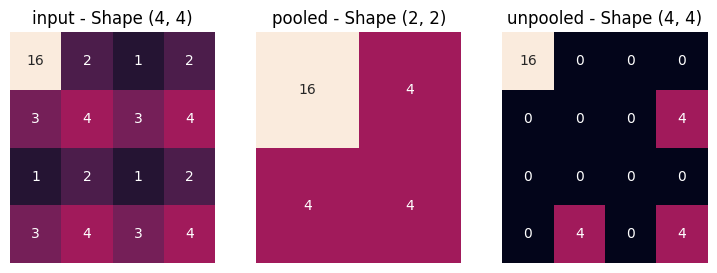

In [29]:
from torch import nn

to_upsample_3 = torch.clone(to_upsample_2)
to_upsample_3[0, 0, 0] = 16

pool = nn.MaxPool2d(2, stride=2, return_indices=True)
unpool = nn.MaxUnpool2d(2, stride=2)
output, indices = pool(to_upsample_3)
unpooled = unpool(output, indices)

display_arrays(
    arrays=[
        np.array(to_upsample_3[0, :, :]),
        np.array(output[0, :, :]),
        np.array(unpooled[0, :, :]),
    ],
    titles=["input", "pooled", "unpooled"],
)

### Transposed Convolution

Test different parameters for _transposed convolution_. Create two more variants and visualize the results.

In [30]:
from torch.nn import functional as F

weight = (
    torch.tensor([[1, 2, 3], [0, 1, 2], [0, 1, 2]])
    .unsqueeze(0)
    .unsqueeze(0)
    .to(torch.float)
)
weight.shape

input_ = to_upsample_2

out = F.conv_transpose2d(
    input=input_, weight=weight, stride=2, padding=0, output_padding=0
)

# YOUR CODE HERE
raise NotImplementedError()

arrays_to_plot = [
    np.array(x)
    for x in [input_[0, ::], weight[0, 0, ::], out[0, ::], out2[0, ::], out3[0, ::]]
]

display_arrays(
    arrays=arrays_to_plot, titles=["Input", "Filter", "Output", "Output2", "Output3"]
)

torch.Size([1, 1, 3, 3])

NotImplementedError: 